In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# Analitik çözümler
def analytical_wavefunction(x, n):
    return np.sqrt(2) * np.sin(n * np.pi * x)

def analytical_energy(n):
    return (np.pi**2 * n**2) / 2

In [ ]:
# Özel aktivasyon fonksiyonu
class MySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)


In [ ]:
# Neural Network sınıfı
class NNs(nn.Module):
    def __init__(self):
        super(NNs, self).__init__()
        self.activation = MySin()
        self.input_En = nn.Linear(1, 1)
        self.hl1 = nn.Linear(2, 50)
        self.hl2 = nn.Linear(50, 50)
        self.output_layer = nn.Linear(50, 1)

    def forward(self, X):
        En_out = self.input_En(torch.ones_like(X))
        hl1_outputs = self.activation(self.hl1(torch.cat((X, En_out), dim=1)))
        hl2_outputs = self.activation(self.hl2(hl1_outputs))
        output = self.output_layer(hl2_outputs)
        return output, En_out

    def wavefunction(self, x):
        x = torch.tensor(x, requires_grad=True).float().view(-1, 1)
        psi, En = self.forward(x)
        wavefunction = (
            (1 - torch.exp(-1.0 * (x - 0))) *
            (1 - torch.exp(-1.0 * (1 - x))) *
            psi[:, 0:1]
        )
        return wavefunction

In [ ]:
# Türev fonksiyonları
def dfx(x, f):
    gopts = torch.ones(x.shape, dtype=torch.float)
    return torch.autograd.grad([f], [x], grad_outputs=gopts, create_graph=True)[0]

def d2fx(x, f):
    gopts = torch.ones(x.shape, dtype=torch.float)
    return torch.autograd.grad(dfx(x, f), [x], grad_outputs=gopts, create_graph=True)[0]

In [ ]:
# Kayıp fonksiyonları

def wavefunction_loss(x, wavefunction, E_predicted):
    psi_dx = dfx(x, wavefunction)
    psi_d2x = d2fx(x, wavefunction)
    residue = (psi_d2x / 2 + E_predicted * wavefunction)
    return (residue.pow(2)).mean()


def normalization_loss(wavefunction):
        norm_loss =((-(torch.dot(wavefunction[:,0],wavefunction[:,0]))+200).pow(2))
        return norm_loss


In [ ]:
class PINNs:
    def __init__(self, X, n=1):
        self.model = NNs()

        # X python listesi veyahut np.array ise float32 tensore dönüştürüyor
        self.X = torch.FloatTensor(X).view(-1, 1).requires_grad_() # !sütun

        self.test_x = np.linspace(0, 1, 200)

        ### Hiperparametreler
        lr=1e-3 # küçükken yavaş - hassas, büyükken hızlı - kararsız
        betas = [0.999, 0.9999] # büyüdükçe yavaş - istikrarlı
        ###

        #
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, betas=(0.999, 0.9999))

        self.Loss_history = []
        self.Phys_loss_history = []
        self.Norm_loss_history = []
        self.henryjin_parameter_history = []

        self.n = n
        self.E_true = analytical_energy(n)


        self.henryjin_parameter = -4
    def loss_henryjin(self, E_predicted):
        return torch.exp((-E_predicted + self.henryjin_parameter)).pow(2)
        """
        Trick: parametreyi sürekli artırarak tahmin edilen enerjiyi artmaya zorluyoruz
        (exp(10) çok büyük bir sayı, hızlı bir şekilde düşürmeye çalışıyor)
        ki farklı n değerleri için dalga fonksiyonumuzu bulalım
        """

    def wavefunction_transform(self,x, wf):
        wf_out = (
            (1 - torch.exp(-1.0 * (x - 0))) *
            (1 - torch.exp(-1.0 * (1 - x))) *
            wf[:, 0:1]
        )
        return wf_out

    def last_wf_En(self, x):
        psi,En = self.model.forward(x)
        psi = self.wavefunction_transform(x,psi)
        return psi,En


    def train(self, epochs=45000):


        for epoch in range(epochs):
            wavefunction, En = self.last_wf_En(self.X)
            phys_loss = wavefunction_loss(self.X, wavefunction, En.mean())
            norm_loss = normalization_loss(wavefunction)


            henryjin_loss = self.loss_henryjin(En.mean())
            total_loss = phys_loss + norm_loss + henryjin_loss


            self.optimizer.zero_grad() #gradyanlarımızı sıfırlıyoruz
            total_loss.backward() # zincir kuralı kullanarak loss fonksiyonlarının gradyanını hesaplıyor
            self.optimizer.step() # parametreleri güncelleniyor..

            # loss çetelesi tutmak için
            self.Loss_history.append(total_loss.item())
            self.Phys_loss_history.append(phys_loss.item())
            self.Norm_loss_history.append(norm_loss.item())

            self.henryjin_parameter_history.append(henryjin_loss.item())

            if epoch % 2500 == 0:
              self.henryjin_parameter += 1
            if epoch % 5000 == 0:
                print(f"Epoch {epoch}, Total Loss: {total_loss.item()}, Schrodinger Loss: {phys_loss.item()}, Norm Loss: {norm_loss.item()}, Energy: {En[0]}, Henryjin Loss: {henryjin_loss.item()}")
                plt.plot(self.test_x, self.evaluate(self.test_x)[0] ) #wavefunction.detach().numpy()
                plt.xlabel("x")
                plt.ylabel("Wavefunction")
                plt.title("Wavefunction Over Epochs")
                plt.show()


    def evaluate(self,x_test_tensor):

        #liste veya arrayse diye
        x_test = torch.FloatTensor(x_test_tensor).view(-1, 1) #!sütun

        # değerlendirme aşamasında parametse güncellemeye gerek yok
        with torch.no_grad(): # bellek kullanımı azaltılıyor, hızlı çalışıyor
           psi,En = self.last_wf_En(x_test)

        return psi,En


    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.Loss_history, label="Total Loss", linewidth=2)
        plt.plot(self.Phys_loss_history, label="Physics Loss", linestyle="--")
        plt.plot(self.Norm_loss_history, label="Normalization Loss", linestyle=":")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Epochs")
        plt.grid(True)
        plt.show()


    def plot_PDE_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.Phys_loss_history, label="Physics Loss")
        plt.xlabel("Epoch")
        plt.ylabel("PDE Loss")
        plt.legend()
        plt.title("PDE Loss Over Epochs")
        plt.grid(True)
        plt.show()


    def plot_Norm_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.Norm_loss_history, label="Normalization Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Normalization Loss")
        plt.legend()
        plt.title("Normalization Loss Over Epochs")
        plt.grid(True)
        plt.show()


    def plot_henryjin_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.henryjin_parameter_history, label="Henryjin Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Henryjin Loss")
        plt.legend()
        plt.title("Henryjin Loss Over Epochs")
        plt.grid(True)
        plt.show()

Epoch 0, Total Loss: 39945.69140625, Schrodinger Loss: 0.02179035171866417, Norm Loss: 39945.66796875, Energy: tensor([0.7011], grad_fn=<SelectBackward0>), Henryjin Loss: 8.253922715084627e-05


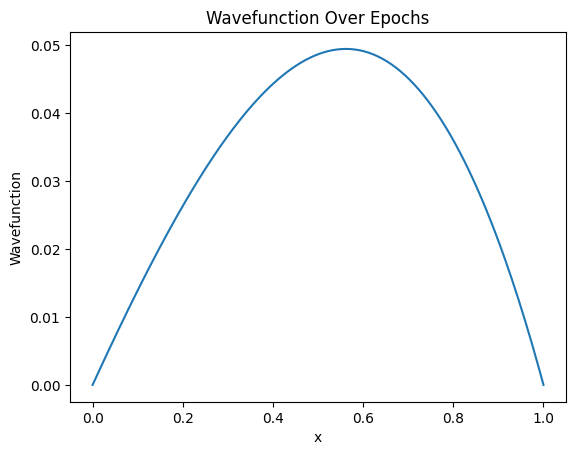

Epoch 5000, Total Loss: 24.918380737304688, Schrodinger Loss: 24.81106948852539, Norm Loss: 0.0977325588464737, Energy: tensor([0.3241], grad_fn=<SelectBackward0>), Henryjin Loss: 0.009578910656273365


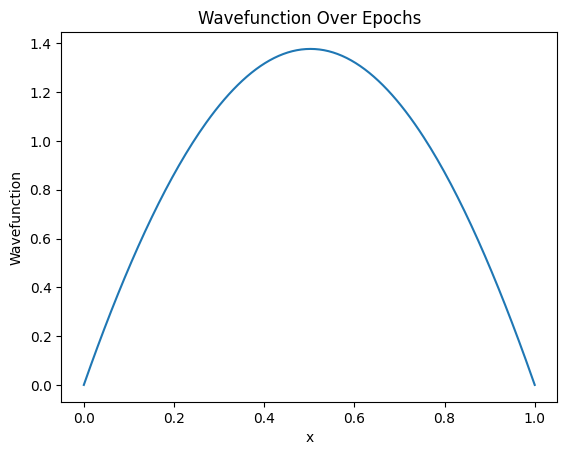

Epoch 10000, Total Loss: 20.782140731811523, Schrodinger Loss: 20.269542694091797, Norm Loss: 0.08795365691184998, Energy: tensor([0.4283], grad_fn=<SelectBackward0>), Henryjin Loss: 0.42464479804039


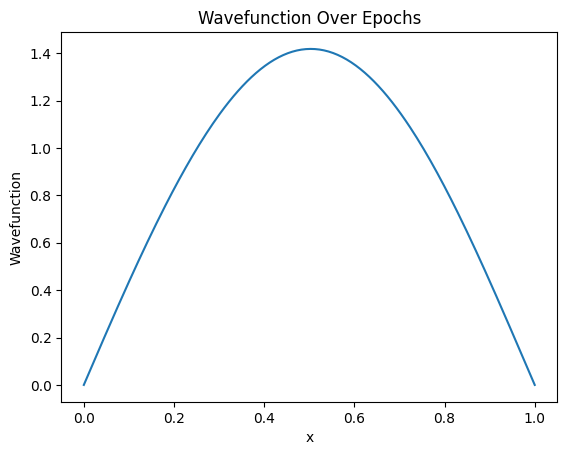

Epoch 15000, Total Loss: 22.58429527282715, Schrodinger Loss: 15.392681121826172, Norm Loss: 0.001753106713294983, Energy: tensor([1.0137], grad_fn=<SelectBackward0>), Henryjin Loss: 7.189861297607422


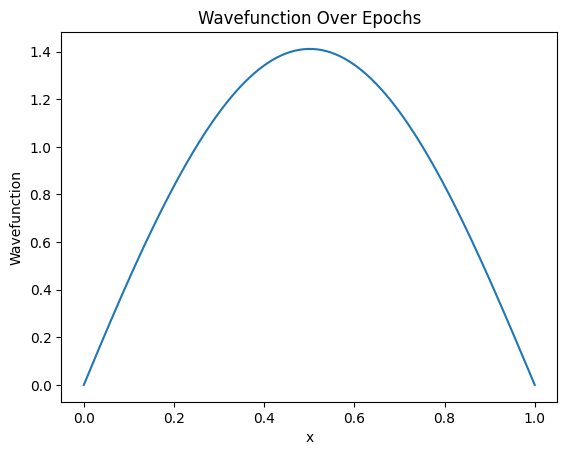

Epoch 20000, Total Loss: 8.969639778137207, Schrodinger Loss: 3.309093952178955, Norm Loss: 4.5486725866794586e-05, Energy: tensor([3.1332], grad_fn=<SelectBackward0>), Henryjin Loss: 5.660500526428223


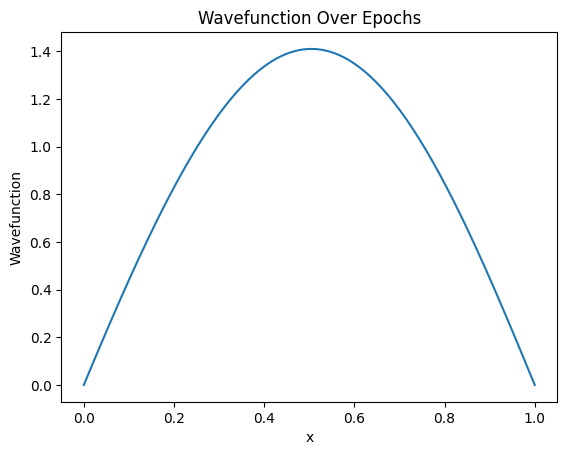

Epoch 25000, Total Loss: 5.049365520477295, Schrodinger Loss: 0.07798389345407486, Norm Loss: 6.728805601596832e-08, Energy: tensor([5.1982], grad_fn=<SelectBackward0>), Henryjin Loss: 4.971381664276123


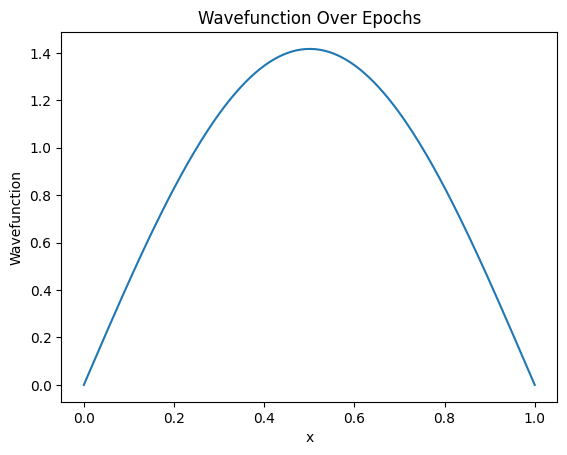

Epoch 30000, Total Loss: 9.856687545776367, Schrodinger Loss: 5.355863094329834, Norm Loss: 0.00019621197134256363, Energy: tensor([7.2479], grad_fn=<SelectBackward0>), Henryjin Loss: 4.50062894821167


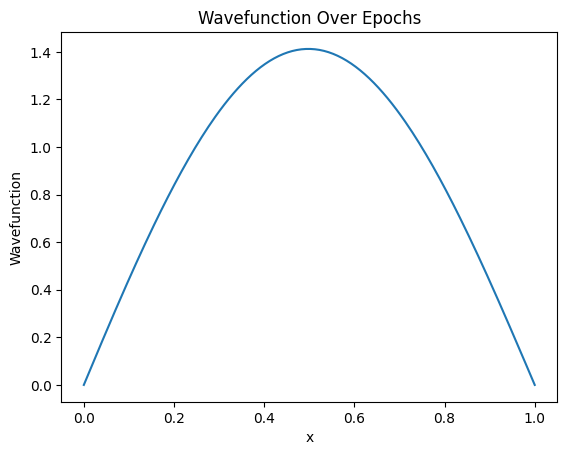

Epoch 35000, Total Loss: 22.939455032348633, Schrodinger Loss: 18.560457229614258, Norm Loss: 0.0021630674600601196, Energy: tensor([9.2618], grad_fn=<SelectBackward0>), Henryjin Loss: 4.376835346221924


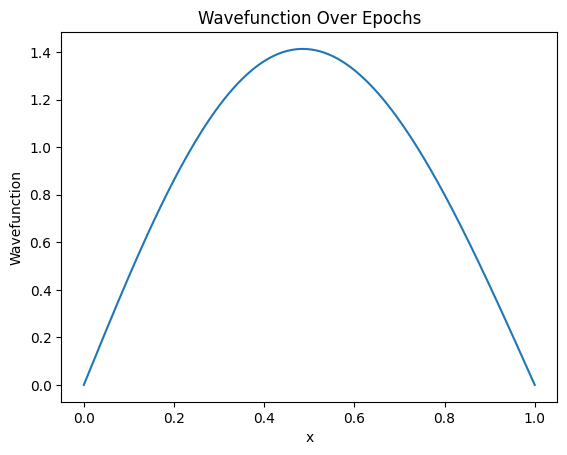

Epoch 40000, Total Loss: 43.369056701660156, Schrodinger Loss: 38.91132736206055, Norm Loss: 0.00933811254799366, Energy: tensor([11.2537], grad_fn=<SelectBackward0>), Henryjin Loss: 4.448389530181885


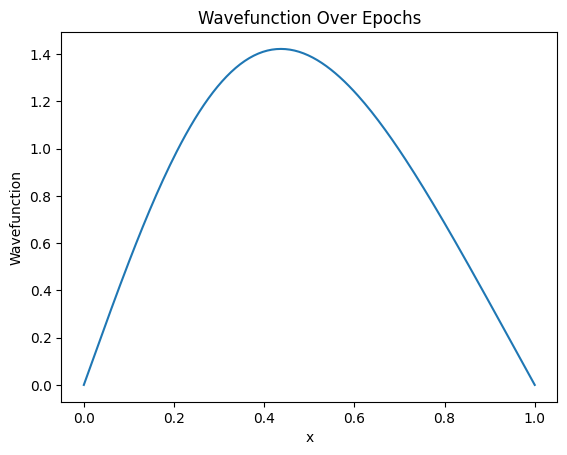

Epoch 45000, Total Loss: 35.59553146362305, Schrodinger Loss: 34.2724494934082, Norm Loss: 0.0052201151847839355, Energy: tensor([13.8620], grad_fn=<SelectBackward0>), Henryjin Loss: 1.3178642988204956


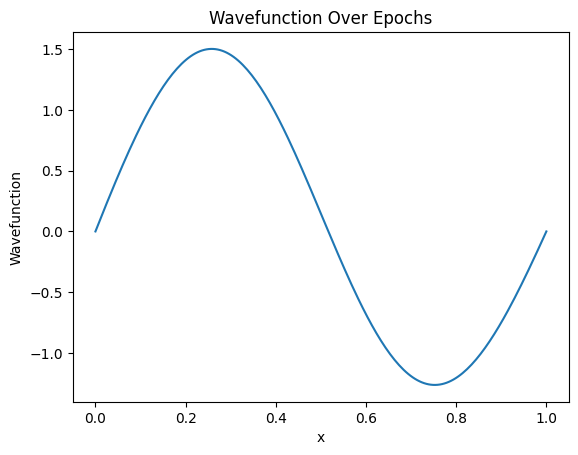

Epoch 50000, Total Loss: 10.397293090820312, Schrodinger Loss: 10.062277793884277, Norm Loss: 0.000644683837890625, Energy: tensor([16.5478], grad_fn=<SelectBackward0>), Henryjin Loss: 0.33437079191207886


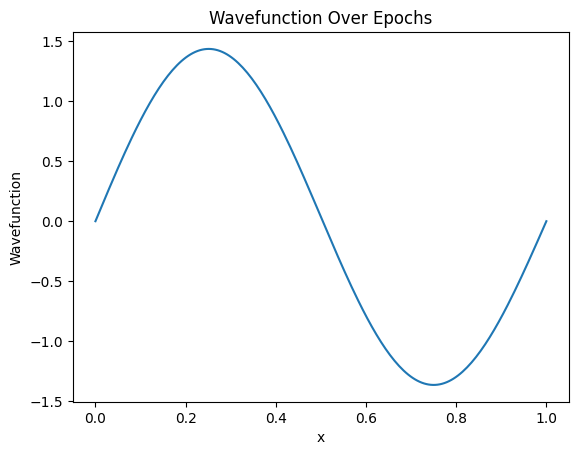

Epoch 55000, Total Loss: 2.341060161590576, Schrodinger Loss: 1.8616790771484375, Norm Loss: 2.597365528345108e-05, Energy: tensor([18.3677], grad_fn=<SelectBackward0>), Henryjin Loss: 0.4793551564216614


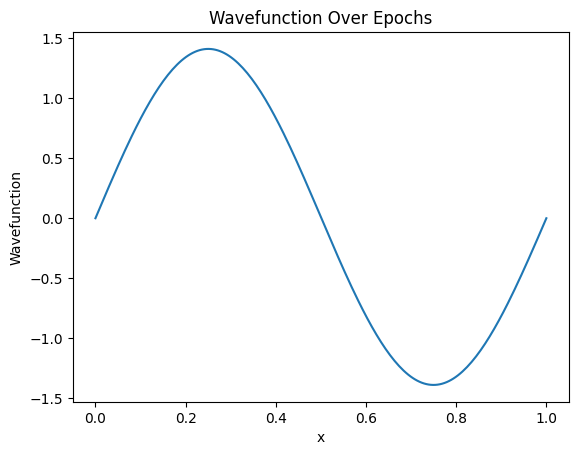

Epoch 60000, Total Loss: 1.0032340288162231, Schrodinger Loss: 0.09994719177484512, Norm Loss: 3.725290298461914e-09, Energy: tensor([20.0509], grad_fn=<SelectBackward0>), Henryjin Loss: 0.903286874294281


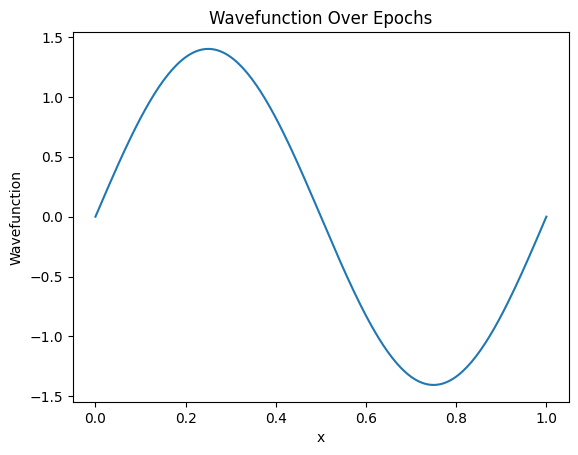

Epoch 65000, Total Loss: 5.7464680671691895, Schrodinger Loss: 4.336028575897217, Norm Loss: 0.00013307109475135803, Energy: tensor([21.8281], grad_fn=<SelectBackward0>), Henryjin Loss: 1.4103065729141235


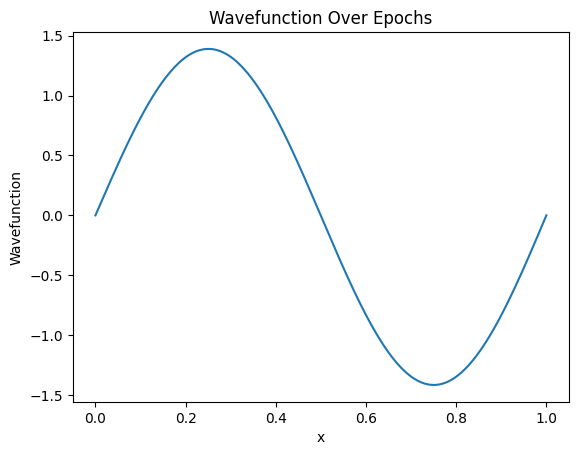

Epoch 70000, Total Loss: 17.073909759521484, Schrodinger Loss: 14.926936149597168, Norm Loss: 0.0014044195413589478, Energy: tensor([23.6183], grad_fn=<SelectBackward0>), Henryjin Loss: 2.145569086074829


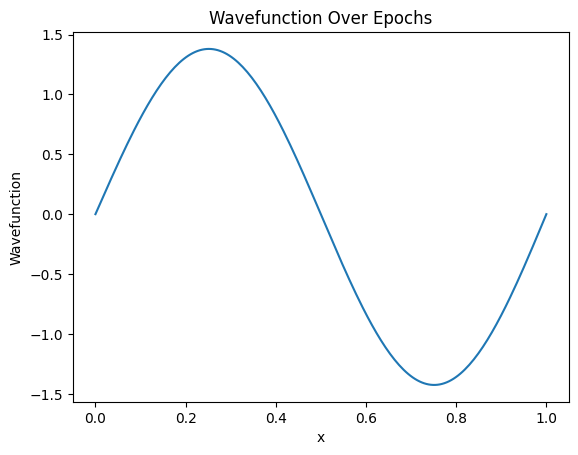

Epoch 75000, Total Loss: 35.02552032470703, Schrodinger Loss: 31.62116241455078, Norm Loss: 0.006319978274405003, Energy: tensor([25.3884], grad_fn=<SelectBackward0>), Henryjin Loss: 3.3980369567871094


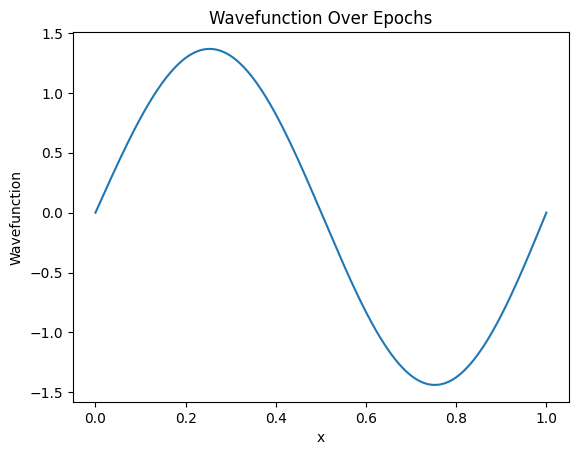

Epoch 80000, Total Loss: 60.01357650756836, Schrodinger Loss: 55.009437561035156, Norm Loss: 0.018888629972934723, Energy: tensor([27.1968], grad_fn=<SelectBackward0>), Henryjin Loss: 4.985249042510986


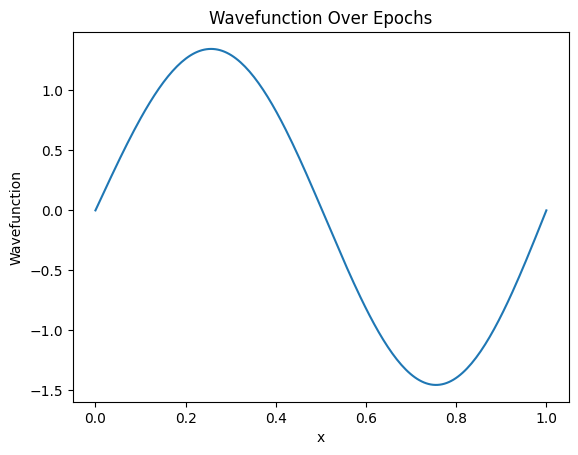

Epoch 85000, Total Loss: 92.42700958251953, Schrodinger Loss: 86.38218688964844, Norm Loss: 0.043222825974226, Energy: tensor([29.1040], grad_fn=<SelectBackward0>), Henryjin Loss: 6.001603126525879


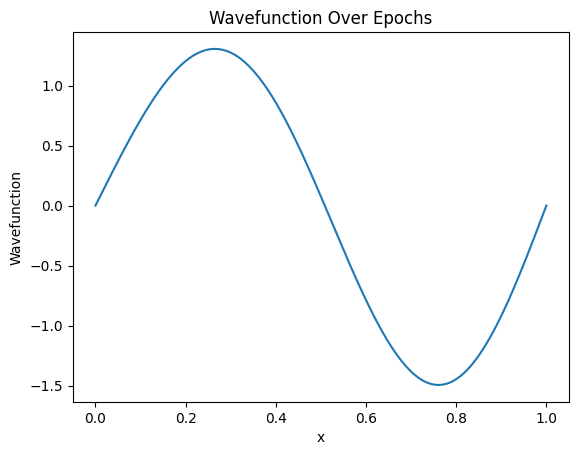

Epoch 90000, Total Loss: 131.91551208496094, Schrodinger Loss: 127.10305786132812, Norm Loss: 0.09489136934280396, Energy: tensor([31.2244], grad_fn=<SelectBackward0>), Henryjin Loss: 4.717563152313232


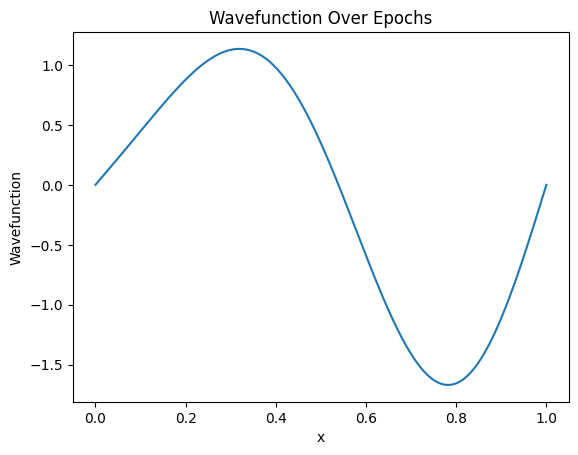

Epoch 95000, Total Loss: 54.87766647338867, Schrodinger Loss: 54.855831146240234, Norm Loss: 0.01917913928627968, Energy: tensor([36.9656], grad_fn=<SelectBackward0>), Henryjin Loss: 0.0026554809883236885


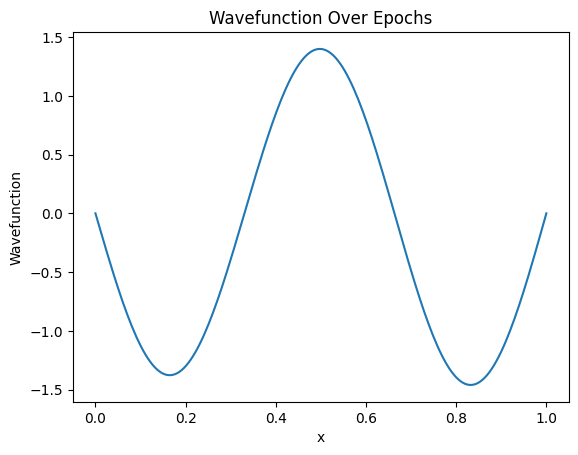

Epoch 100000, Total Loss: 4.43526029586792, Schrodinger Loss: 4.435156345367432, Norm Loss: 0.00010050111450254917, Energy: tensor([42.2982], grad_fn=<SelectBackward0>), Henryjin Loss: 3.3838493891380494e-06


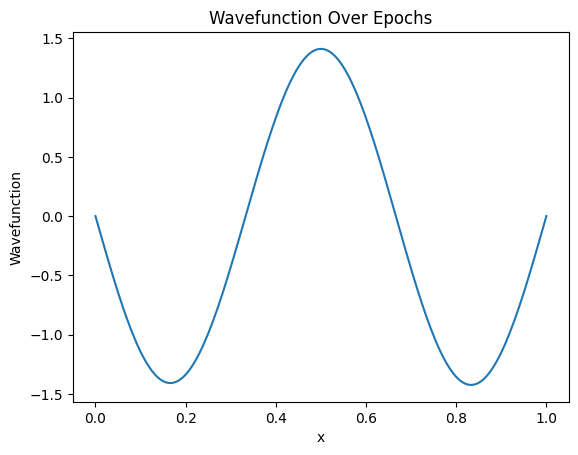

Epoch 105000, Total Loss: 0.11350087821483612, Schrodinger Loss: 0.11349566280841827, Norm Loss: 0.0, Energy: tensor([44.0817], grad_fn=<SelectBackward0>), Henryjin Loss: 5.218027581577189e-06


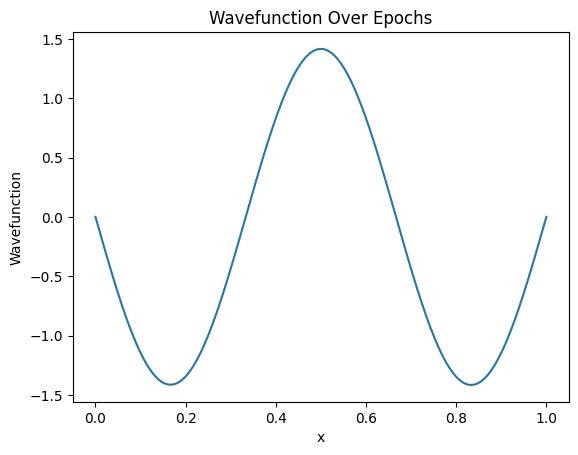

Epoch 110000, Total Loss: 0.0023973893839865923, Schrodinger Loss: 0.0022484923247247934, Norm Loss: 1.1408701539039612e-08, Energy: tensor([44.4062], grad_fn=<SelectBackward0>), Henryjin Loss: 0.00014888562145642936


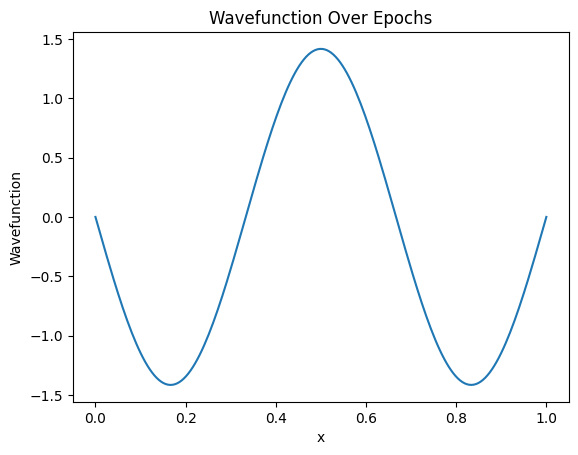

Epoch 115000, Total Loss: 0.008395357988774776, Schrodinger Loss: 0.0004592931654769927, Norm Loss: 3.3620744943618774e-07, Energy: tensor([44.4182], grad_fn=<SelectBackward0>), Henryjin Loss: 0.007935728877782822


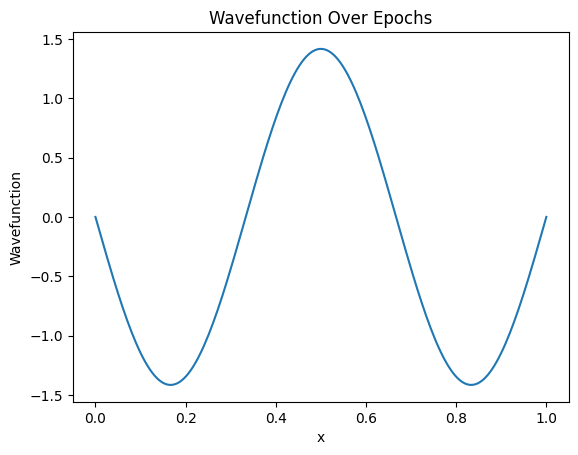

Epoch 120000, Total Loss: 0.32697027921676636, Schrodinger Loss: 0.06728227436542511, Norm Loss: 9.313225746154785e-10, Energy: tensor([44.6741], grad_fn=<SelectBackward0>), Henryjin Loss: 0.25968801975250244


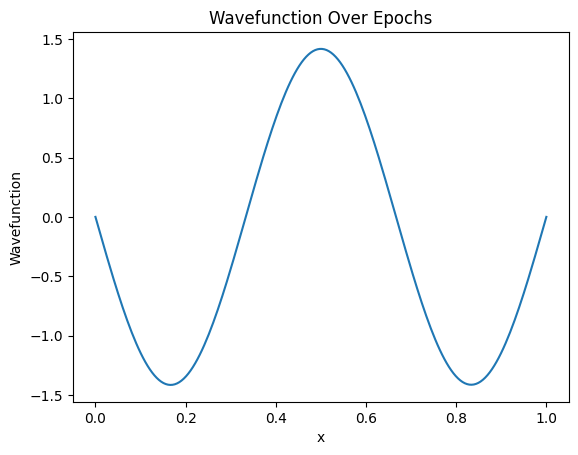

Epoch 125000, Total Loss: 3.4782450199127197, Schrodinger Loss: 2.4568870067596436, Norm Loss: 3.067986108362675e-05, Energy: tensor([45.9894], grad_fn=<SelectBackward0>), Henryjin Loss: 1.021327257156372


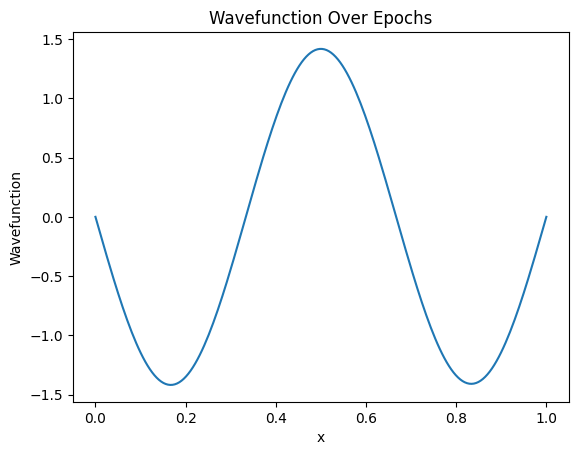

Epoch 130000, Total Loss: 12.121963500976562, Schrodinger Loss: 9.146133422851562, Norm Loss: 0.0003868530038744211, Energy: tensor([47.4548], grad_fn=<SelectBackward0>), Henryjin Loss: 2.9754433631896973


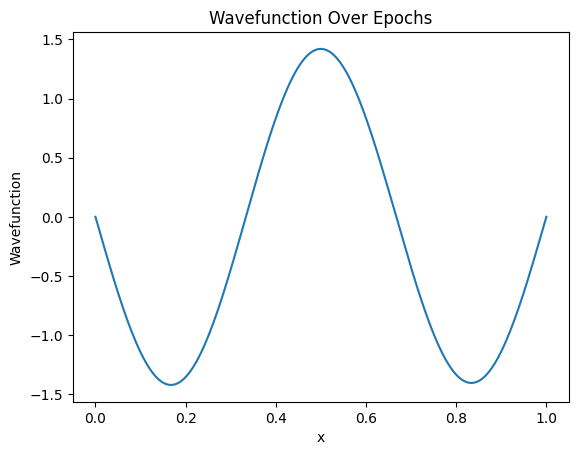

Epoch 135000, Total Loss: 27.71546745300293, Schrodinger Loss: 23.934423446655273, Norm Loss: 0.0035123564302921295, Energy: tensor([49.3355], grad_fn=<SelectBackward0>), Henryjin Loss: 3.7775325775146484


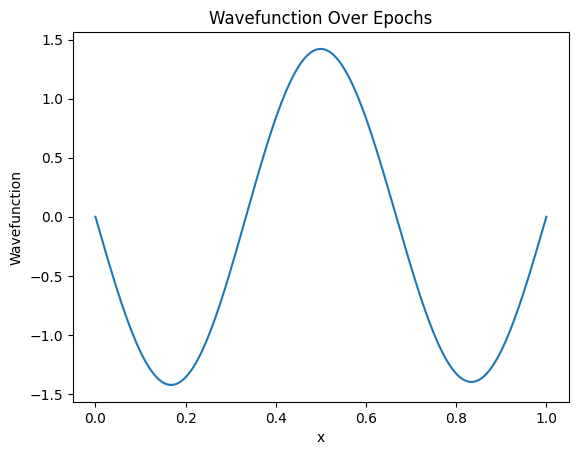

Epoch 140000, Total Loss: 50.46533966064453, Schrodinger Loss: 45.62299728393555, Norm Loss: 0.01349788997322321, Energy: tensor([51.2127], grad_fn=<SelectBackward0>), Henryjin Loss: 4.828847885131836


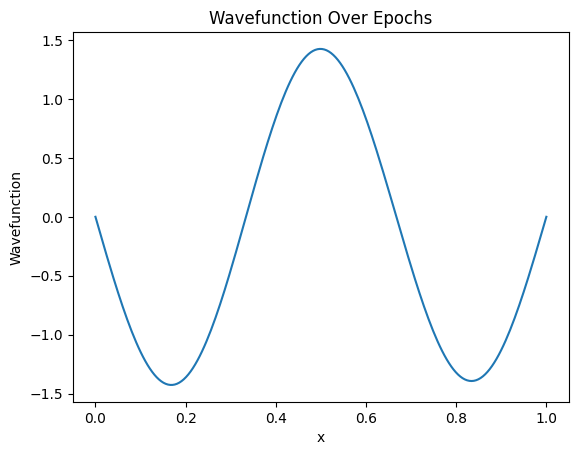

Epoch 145000, Total Loss: 80.12935638427734, Schrodinger Loss: 74.24124908447266, Norm Loss: 0.03244132176041603, Energy: tensor([53.1163], grad_fn=<SelectBackward0>), Henryjin Loss: 5.855669021606445


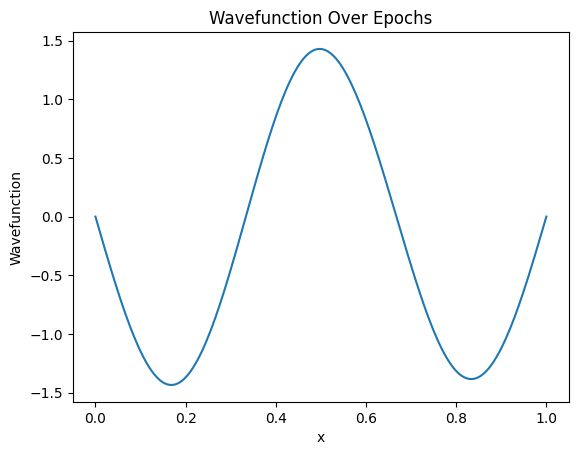

Epoch 150000, Total Loss: 116.81121826171875, Schrodinger Loss: 109.86830139160156, Norm Loss: 0.07707197964191437, Energy: tensor([55.0367], grad_fn=<SelectBackward0>), Henryjin Loss: 6.865847587585449


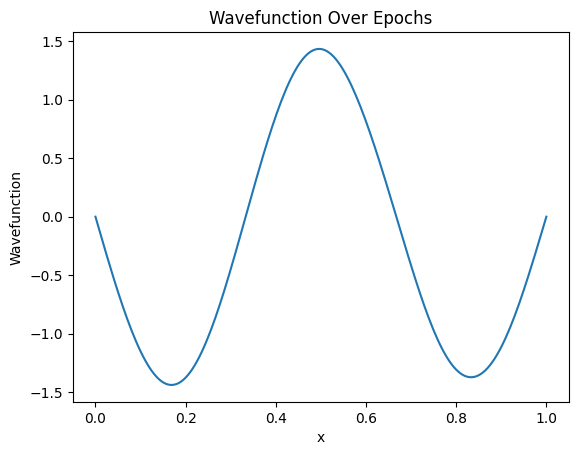

Epoch 155000, Total Loss: 161.2337646484375, Schrodinger Loss: 153.19583129882812, Norm Loss: 0.14887945353984833, Energy: tensor([56.9673], grad_fn=<SelectBackward0>), Henryjin Loss: 7.889048099517822


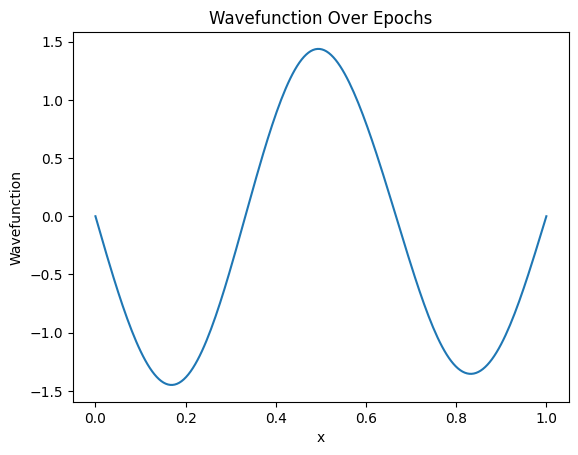

Epoch 160000, Total Loss: 212.5980987548828, Schrodinger Loss: 203.49160766601562, Norm Loss: 0.2662469148635864, Energy: tensor([58.9103], grad_fn=<SelectBackward0>), Henryjin Loss: 8.84023666381836


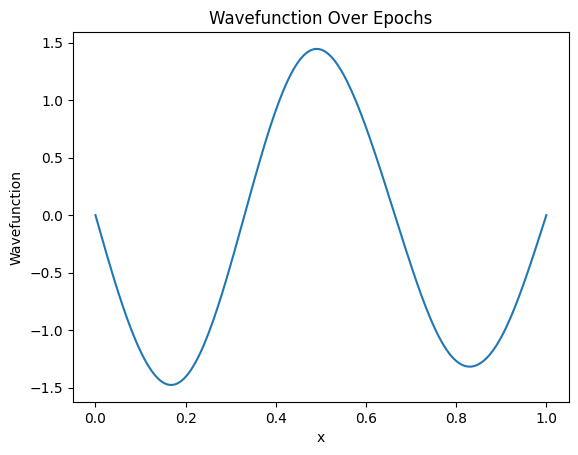

Epoch 165000, Total Loss: 243.1332244873047, Schrodinger Loss: 237.36009216308594, Norm Loss: 0.3903961479663849, Energy: tensor([61.1584], grad_fn=<SelectBackward0>), Henryjin Loss: 5.382737159729004


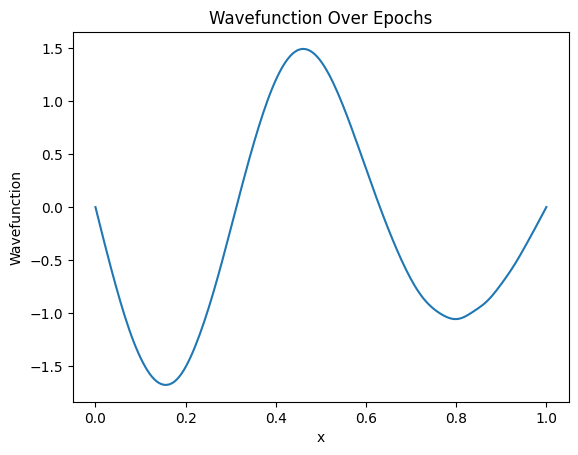

Epoch 170000, Total Loss: 121.2780532836914, Schrodinger Loss: 121.17847442626953, Norm Loss: 0.09790436178445816, Energy: tensor([67.1983], grad_fn=<SelectBackward0>), Henryjin Loss: 0.0016671291086822748


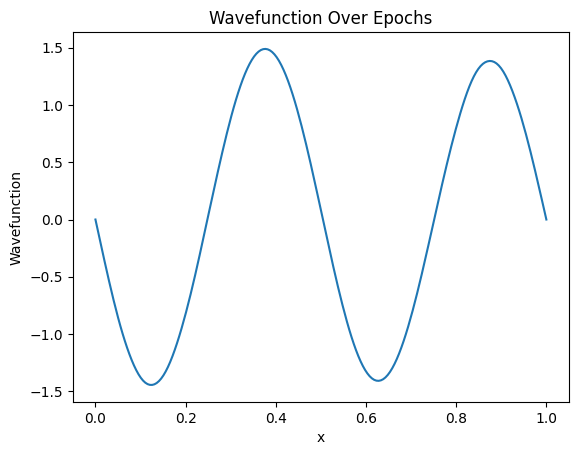

Epoch 175000, Total Loss: 31.338186264038086, Schrodinger Loss: 31.332895278930664, Norm Loss: 0.005290910601615906, Energy: tensor([72.9553], grad_fn=<SelectBackward0>), Henryjin Loss: 9.093344033317408e-07


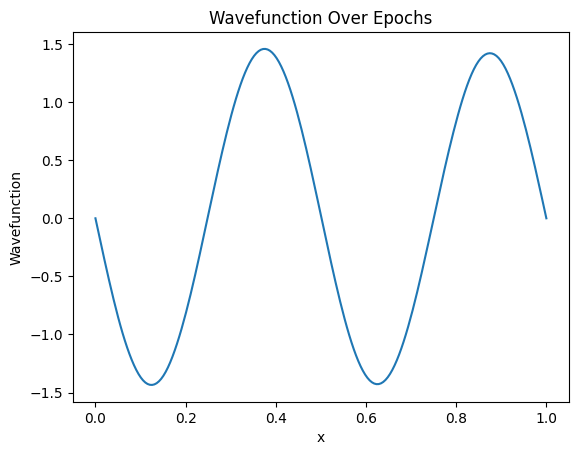

Epoch 180000, Total Loss: 5.5306220054626465, Schrodinger Loss: 5.530450820922852, Norm Loss: 0.00017140153795480728, Energy: tensor([76.4344], grad_fn=<SelectBackward0>), Henryjin Loss: 4.720171986605237e-08


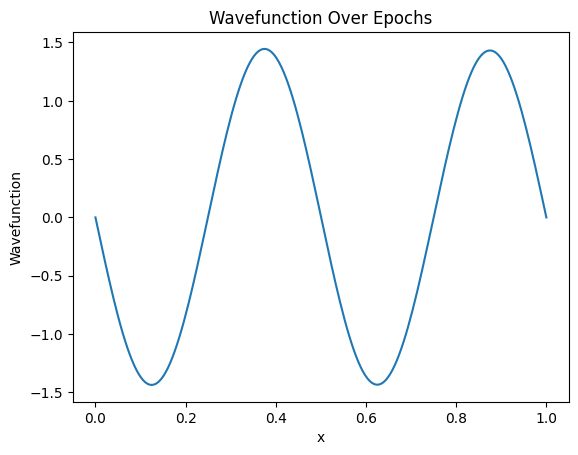

Epoch 185000, Total Loss: 0.5263416767120361, Schrodinger Loss: 0.5263408422470093, Norm Loss: 7.832422852516174e-07, Energy: tensor([78.1793], grad_fn=<SelectBackward0>), Henryjin Loss: 7.862936968194845e-08


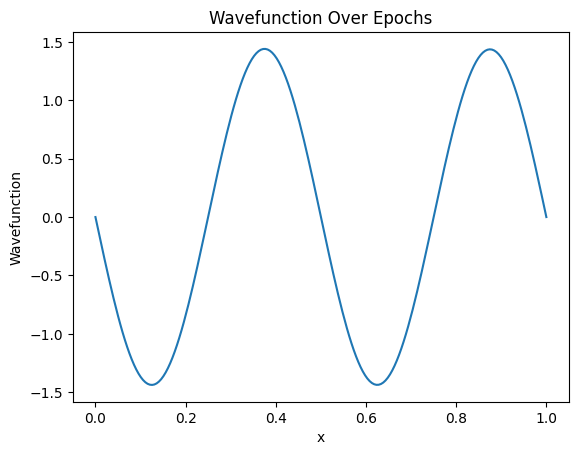

Epoch 190000, Total Loss: 0.01785690151154995, Schrodinger Loss: 0.017854681238532066, Norm Loss: 1.014210283756256e-06, Energy: tensor([78.8143], grad_fn=<SelectBackward0>), Henryjin Loss: 1.20544473247719e-06


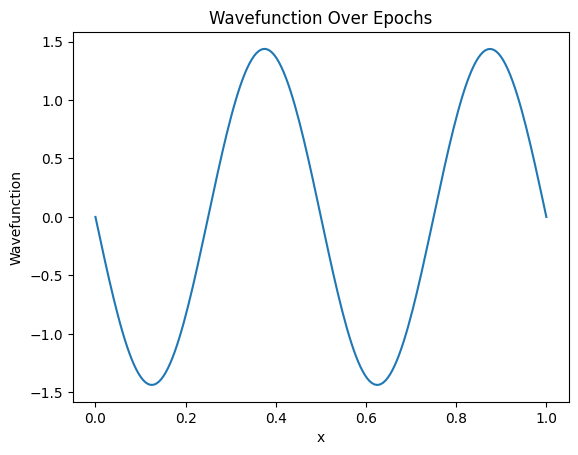

Epoch 195000, Total Loss: 0.00015170635015238076, Schrodinger Loss: 0.00010087380360346287, Norm Loss: 5.364418029785156e-07, Energy: tensor([78.9488], grad_fn=<SelectBackward0>), Henryjin Loss: 5.029610110796057e-05


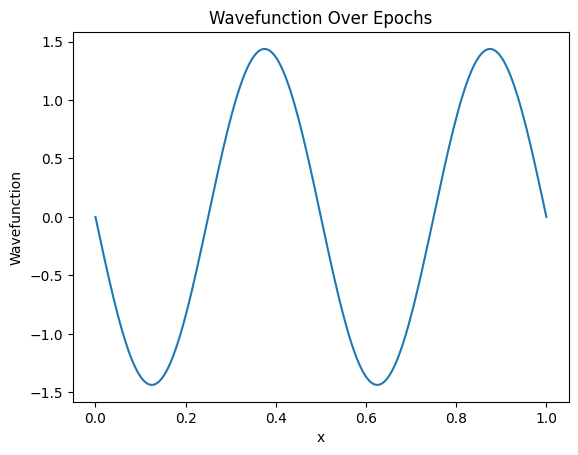

Epoch 200000, Total Loss: 0.0027395004872232676, Schrodinger Loss: 3.0013763534952886e-05, Norm Loss: 1.5276018530130386e-06, Energy: tensor([78.9558], grad_fn=<SelectBackward0>), Henryjin Loss: 0.0027079591527581215


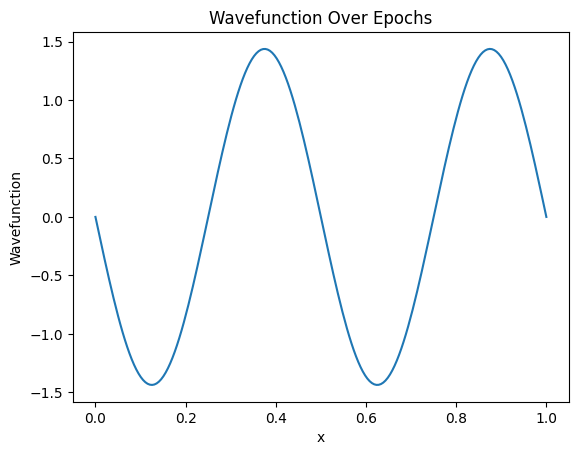

Epoch 205000, Total Loss: 0.12911397218704224, Schrodinger Loss: 0.010950636118650436, Norm Loss: 9.477231651544571e-05, Energy: tensor([79.0682], grad_fn=<SelectBackward0>), Henryjin Loss: 0.11806856095790863


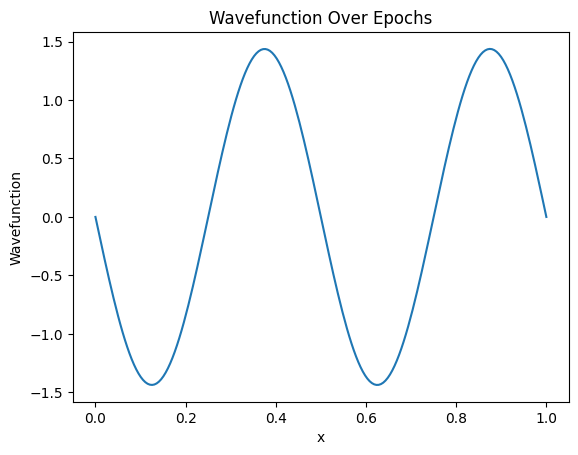

Epoch 210000, Total Loss: 2.02815318107605, Schrodinger Loss: 1.3785725831985474, Norm Loss: 2.8848648071289062e-05, Energy: tensor([80.2157], grad_fn=<SelectBackward0>), Henryjin Loss: 0.6495517492294312


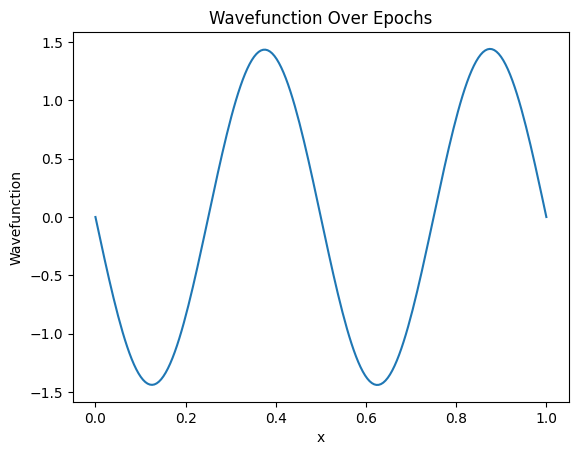

Epoch 215000, Total Loss: 8.2948579788208, Schrodinger Loss: 6.059934139251709, Norm Loss: 0.0010405192151665688, Energy: tensor([81.5981], grad_fn=<SelectBackward0>), Henryjin Loss: 2.2338831424713135


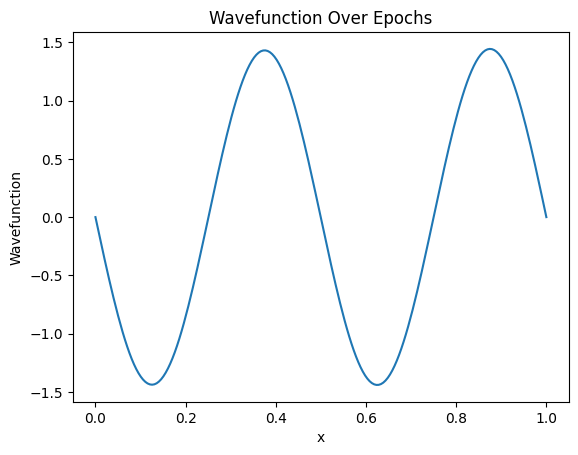

Epoch 220000, Total Loss: 20.523422241210938, Schrodinger Loss: 17.533985137939453, Norm Loss: 0.0017086698208004236, Energy: tensor([83.4528], grad_fn=<SelectBackward0>), Henryjin Loss: 2.987727165222168


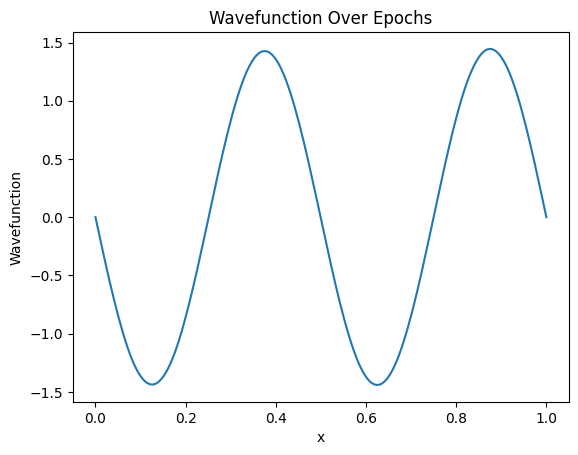

Epoch 225000, Total Loss: 38.85162353515625, Schrodinger Loss: 34.8218994140625, Norm Loss: 0.0072755152359604836, Energy: tensor([85.3040], grad_fn=<SelectBackward0>), Henryjin Loss: 4.022451400756836


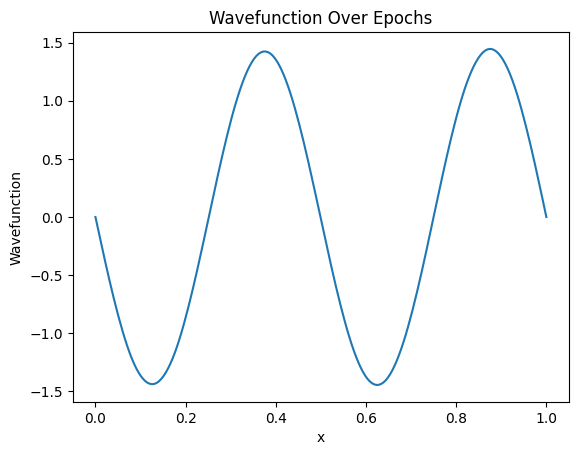

Epoch 230000, Total Loss: 62.81732940673828, Schrodinger Loss: 57.985652923583984, Norm Loss: 0.019783973693847656, Energy: tensor([87.2145], grad_fn=<SelectBackward0>), Henryjin Loss: 4.811893463134766


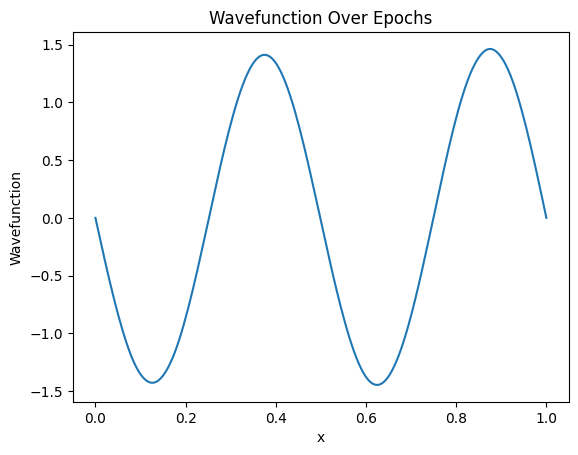

Epoch 235000, Total Loss: 91.9670639038086, Schrodinger Loss: 86.2947006225586, Norm Loss: 0.04900667443871498, Energy: tensor([89.1365], grad_fn=<SelectBackward0>), Henryjin Loss: 5.623356342315674


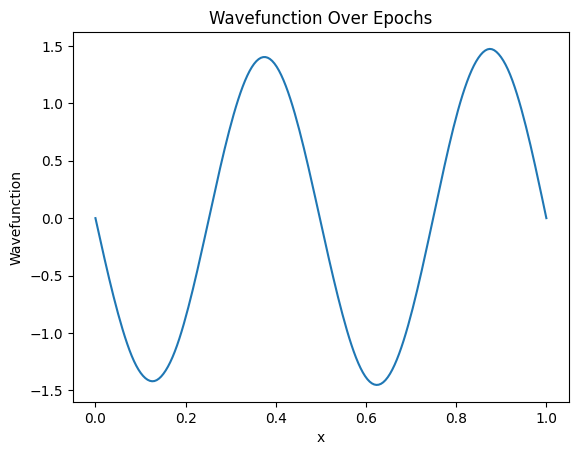

Epoch 240000, Total Loss: 127.99708557128906, Schrodinger Loss: 121.37657165527344, Norm Loss: 0.09043264389038086, Energy: tensor([91.0618], grad_fn=<SelectBackward0>), Henryjin Loss: 6.530079364776611


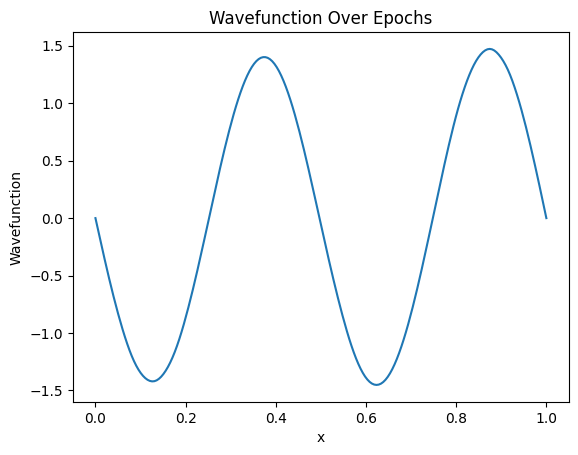

Epoch 245000, Total Loss: 170.26710510253906, Schrodinger Loss: 162.66558837890625, Norm Loss: 0.1841071993112564, Energy: tensor([92.9981], grad_fn=<SelectBackward0>), Henryjin Loss: 7.417409420013428


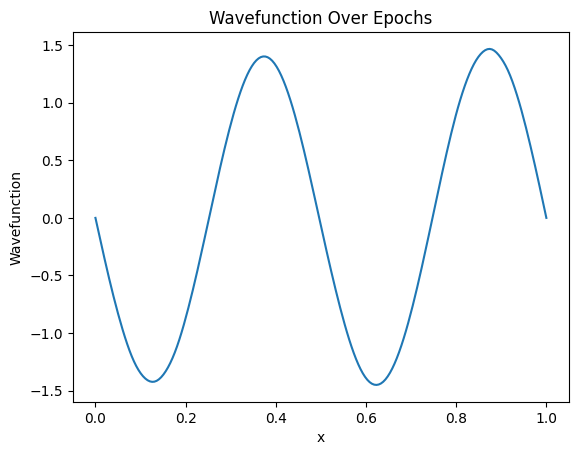

Epoch 250000, Total Loss: 218.9917755126953, Schrodinger Loss: 210.4258575439453, Norm Loss: 0.27717486023902893, Energy: tensor([94.9425], grad_fn=<SelectBackward0>), Henryjin Loss: 8.28874683380127


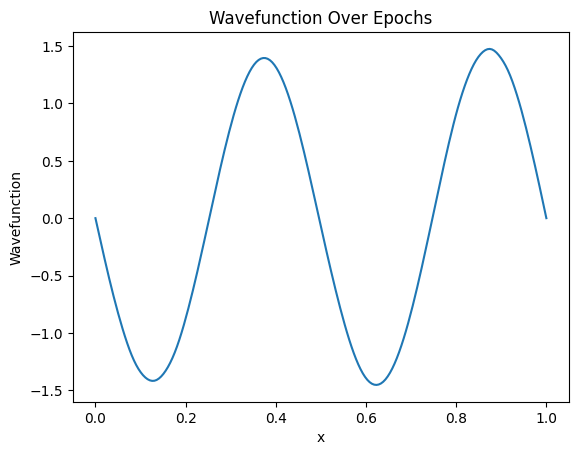

Epoch 255000, Total Loss: 273.22833251953125, Schrodinger Loss: 263.7478942871094, Norm Loss: 0.45131349563598633, Energy: tensor([96.8998], grad_fn=<SelectBackward0>), Henryjin Loss: 9.029118537902832


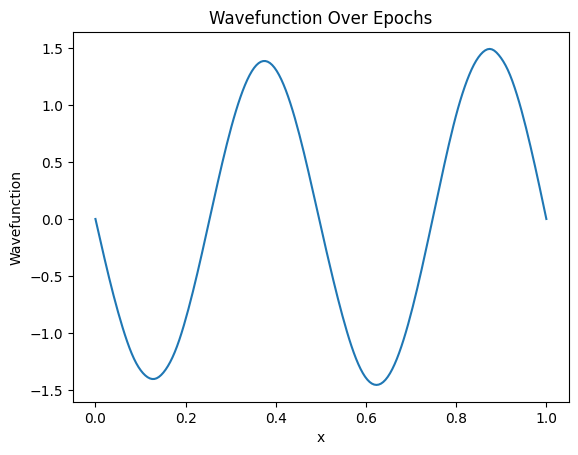

Epoch 260000, Total Loss: 333.71685791015625, Schrodinger Loss: 323.0725402832031, Norm Loss: 0.6547124981880188, Energy: tensor([98.8492], grad_fn=<SelectBackward0>), Henryjin Loss: 9.98959732055664


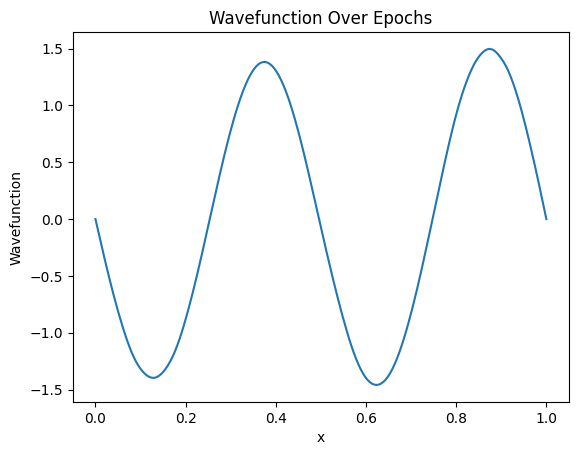

Epoch 265000, Total Loss: 369.8719787597656, Schrodinger Loss: 366.1566467285156, Norm Loss: 0.989772379398346, Energy: tensor([101.4986], grad_fn=<SelectBackward0>), Henryjin Loss: 2.7255499362945557


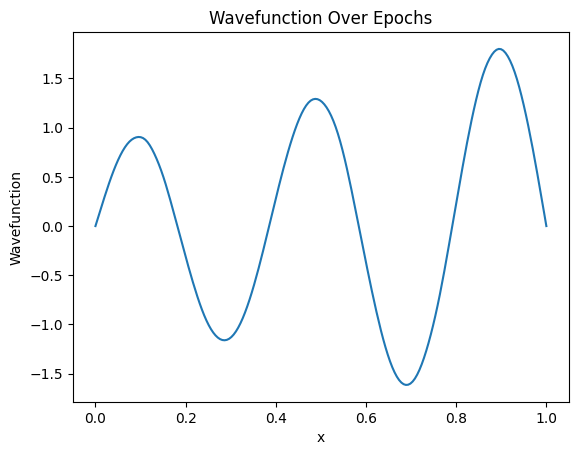

Epoch 270000, Total Loss: 165.7694854736328, Schrodinger Loss: 165.6049346923828, Norm Loss: 0.16444450616836548, Energy: tensor([108.5954], grad_fn=<SelectBackward0>), Henryjin Loss: 0.00010198301606578752


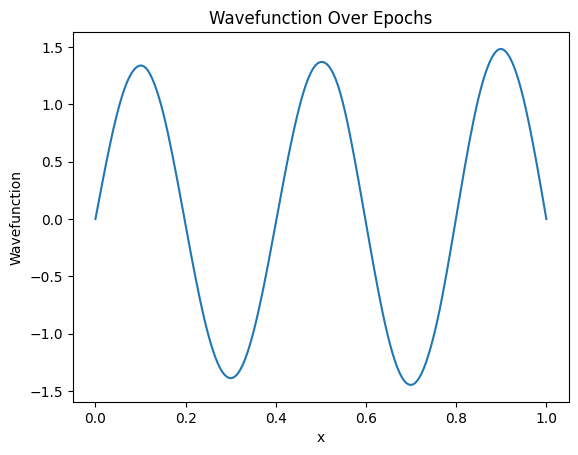

Epoch 275000, Total Loss: 69.74283599853516, Schrodinger Loss: 69.71411895751953, Norm Loss: 0.02871808409690857, Energy: tensor([113.6329], grad_fn=<SelectBackward0>), Henryjin Loss: 2.3450050434803416e-07


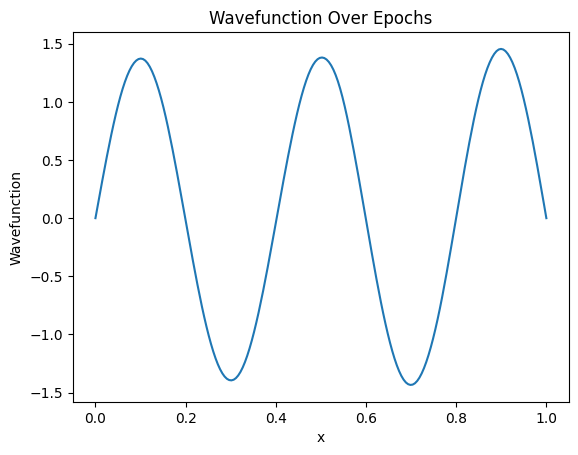

Epoch 280000, Total Loss: 25.527904510498047, Schrodinger Loss: 25.5241641998291, Norm Loss: 0.0037402063608169556, Energy: tensor([117.4716], grad_fn=<SelectBackward0>), Henryjin Loss: 5.929844615337743e-09


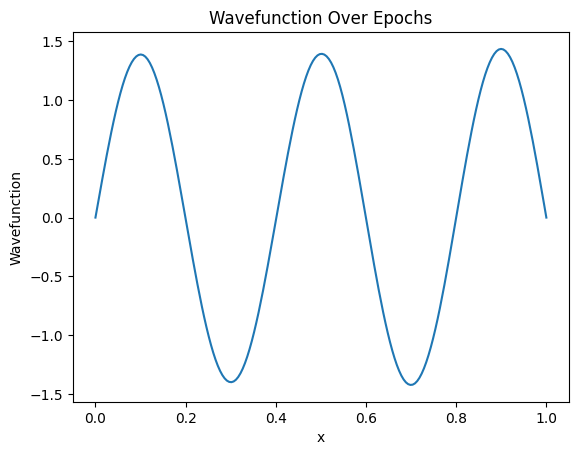

Epoch 285000, Total Loss: 7.011488437652588, Schrodinger Loss: 7.011108875274658, Norm Loss: 0.00037968368269503117, Energy: tensor([120.2802], grad_fn=<SelectBackward0>), Henryjin Loss: 1.1770110441844395e-09


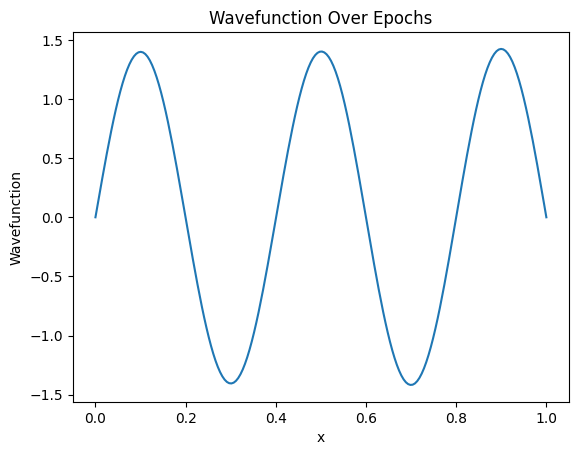

Epoch 290000, Total Loss: 1.2685322761535645, Schrodinger Loss: 1.268532156944275, Norm Loss: 9.313225746154785e-08, Energy: tensor([122.0584], grad_fn=<SelectBackward0>), Henryjin Loss: 1.8338434104592238e-09


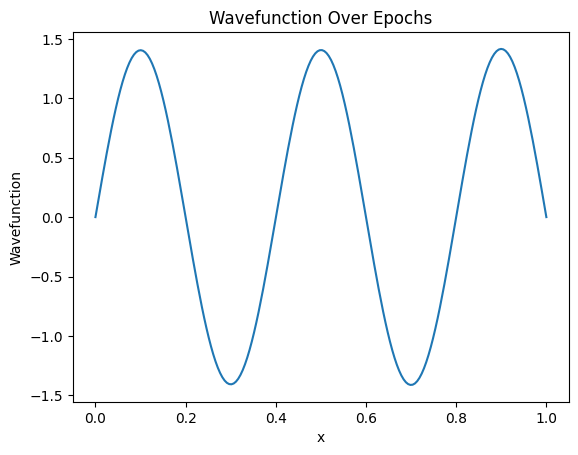

Epoch 295000, Total Loss: 0.1271412968635559, Schrodinger Loss: 0.1271350234746933, Norm Loss: 6.2622129917144775e-06, Energy: tensor([122.9609], grad_fn=<SelectBackward0>), Henryjin Loss: 1.6470048436190154e-08


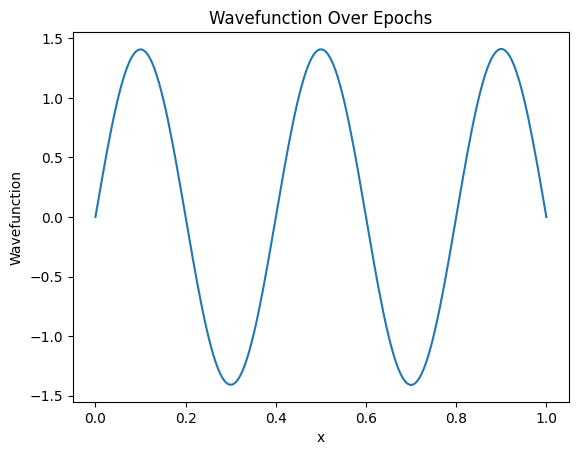

Epoch 300000, Total Loss: 0.00802291464060545, Schrodinger Loss: 0.00798739492893219, Norm Loss: 3.505125641822815e-05, Energy: tensor([123.2869], grad_fn=<SelectBackward0>), Henryjin Loss: 4.684281691424985e-07


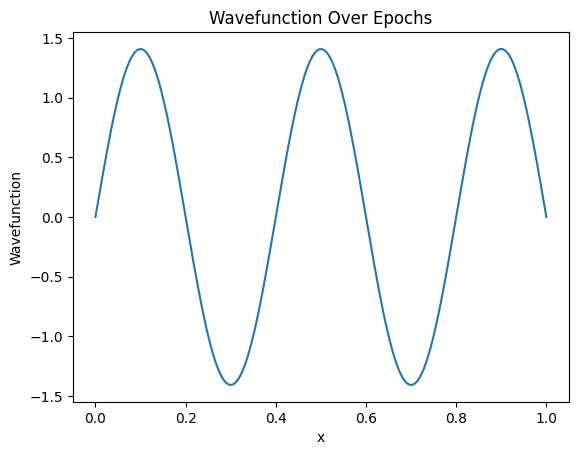

Epoch 305000, Total Loss: 0.002064416417852044, Schrodinger Loss: 0.0019242737907916307, Norm Loss: 0.00011803209781646729, Energy: tensor([123.3597], grad_fn=<SelectBackward0>), Henryjin Loss: 2.211063474533148e-05


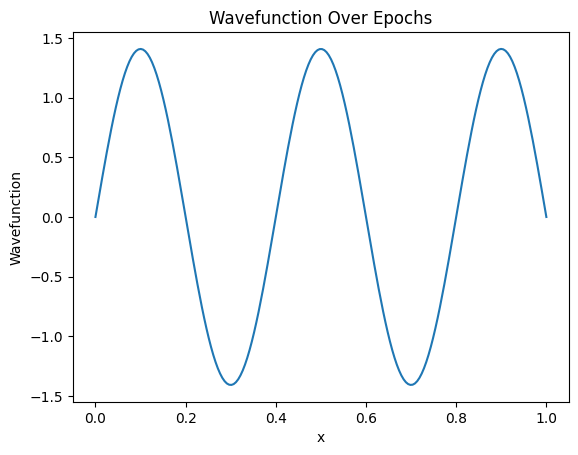

Epoch 310000, Total Loss: 0.0028971307910978794, Schrodinger Loss: 0.001504214364103973, Norm Loss: 0.00018943194299936295, Energy: tensor([123.3613], grad_fn=<SelectBackward0>), Henryjin Loss: 0.0012034844839945436


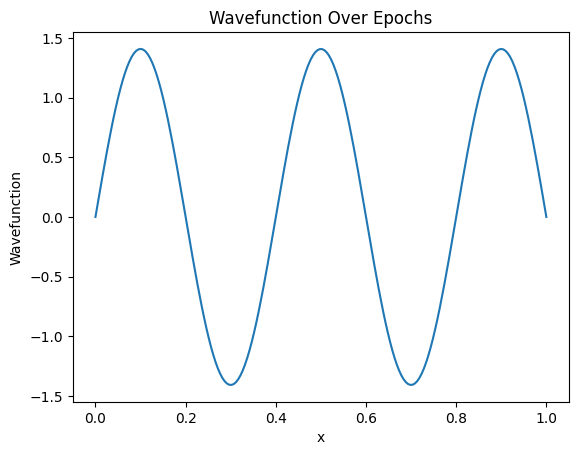

Epoch 315000, Total Loss: 0.061359703540802, Schrodinger Loss: 0.0036669743712991476, Norm Loss: 2.414081245660782e-05, Energy: tensor([123.4265], grad_fn=<SelectBackward0>), Henryjin Loss: 0.05766858905553818


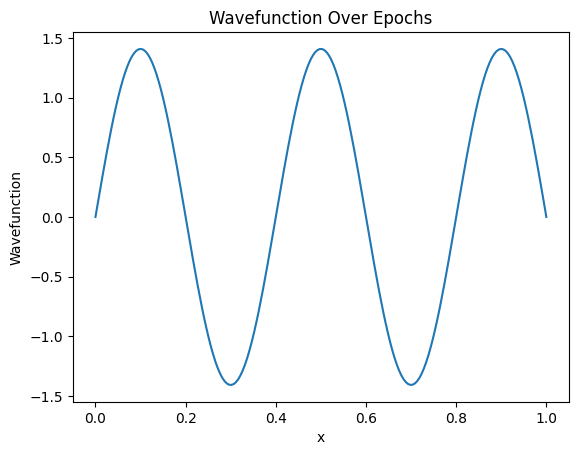

Epoch 320000, Total Loss: 1.2393951416015625, Schrodinger Loss: 0.787233829498291, Norm Loss: 9.656324982643127e-05, Energy: tensor([124.3970], grad_fn=<SelectBackward0>), Henryjin Loss: 0.4520646929740906


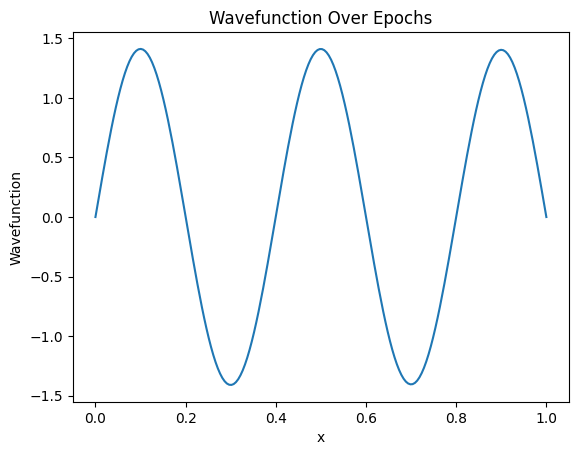

Epoch 325000, Total Loss: 5.827823162078857, Schrodinger Loss: 4.144861698150635, Norm Loss: 2.470100298523903e-06, Energy: tensor([125.7397], grad_fn=<SelectBackward0>), Henryjin Loss: 1.6829590797424316


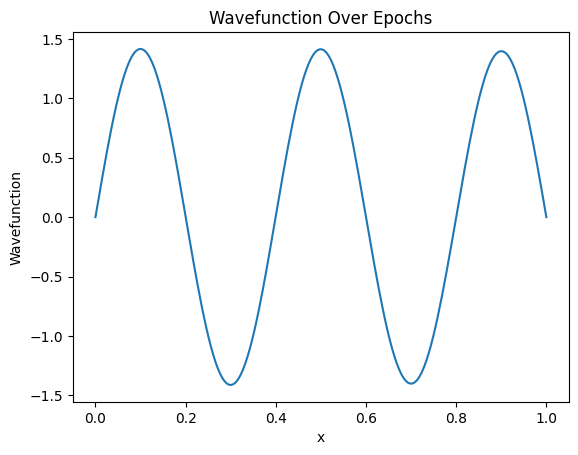

Epoch 330000, Total Loss: 15.294185638427734, Schrodinger Loss: 12.879324913024902, Norm Loss: 0.00026806467212736607, Energy: tensor([127.5592], grad_fn=<SelectBackward0>), Henryjin Loss: 2.414592981338501


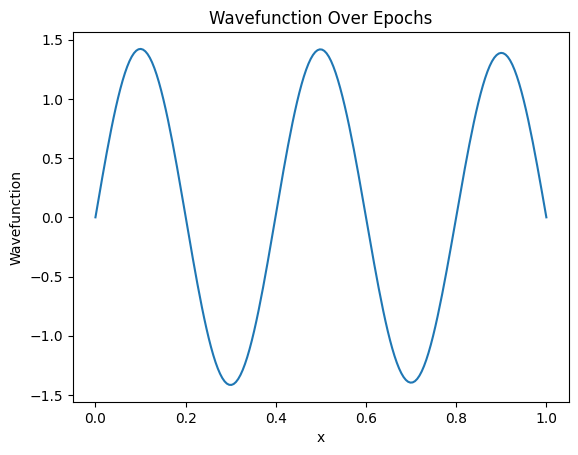

Epoch 335000, Total Loss: 29.92764663696289, Schrodinger Loss: 26.66895294189453, Norm Loss: 0.008909636177122593, Energy: tensor([129.4107], grad_fn=<SelectBackward0>), Henryjin Loss: 3.2497849464416504


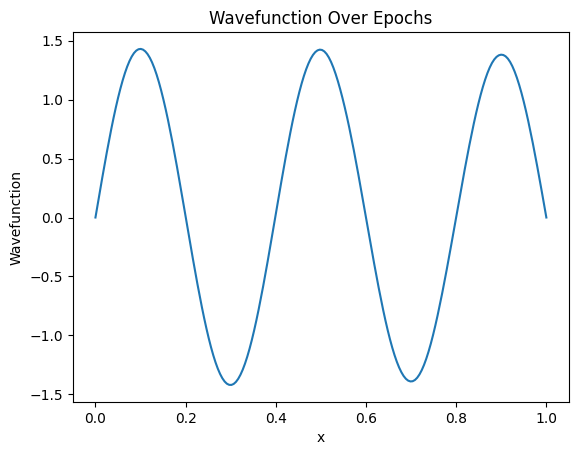

Epoch 340000, Total Loss: 49.93301010131836, Schrodinger Loss: 45.87892532348633, Norm Loss: 0.01644418016076088, Energy: tensor([131.3022], grad_fn=<SelectBackward0>), Henryjin Loss: 4.03764009475708


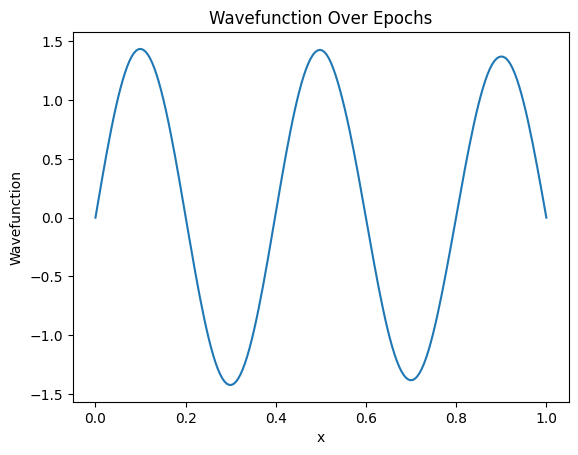

Epoch 345000, Total Loss: 75.42243194580078, Schrodinger Loss: 70.6047134399414, Norm Loss: 0.023190025240182877, Energy: tensor([133.2163], grad_fn=<SelectBackward0>), Henryjin Loss: 4.7945237159729


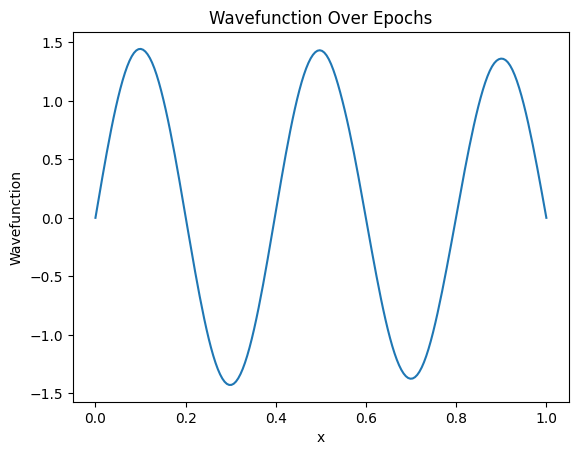

Epoch 350000, Total Loss: 106.3922119140625, Schrodinger Loss: 100.75363159179688, Norm Loss: 0.07140220701694489, Energy: tensor([135.1415], grad_fn=<SelectBackward0>), Henryjin Loss: 5.567179203033447


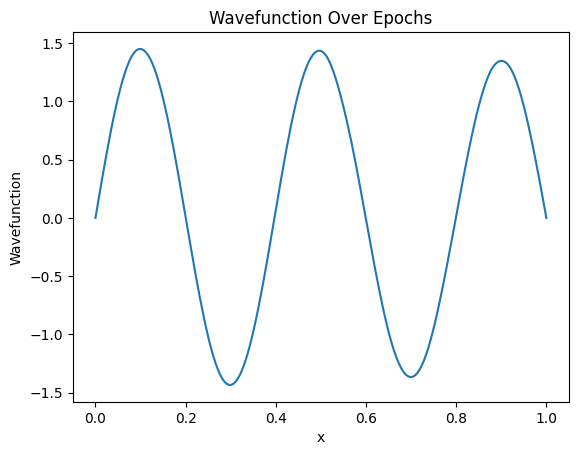

Epoch 355000, Total Loss: 142.83981323242188, Schrodinger Loss: 136.39169311523438, Norm Loss: 0.11536934971809387, Energy: tensor([137.0771], grad_fn=<SelectBackward0>), Henryjin Loss: 6.332744598388672


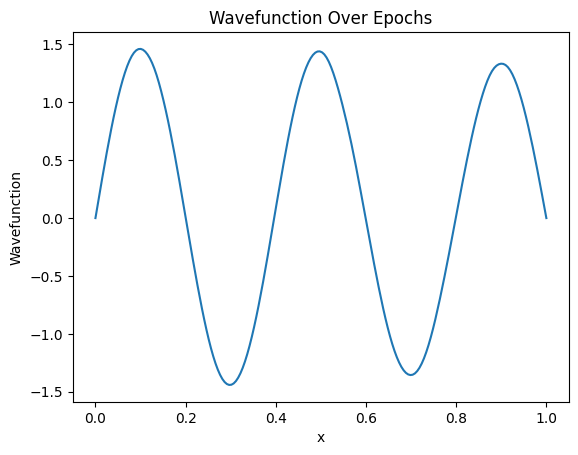

Epoch 360000, Total Loss: 184.7578125, Schrodinger Loss: 177.48544311523438, Norm Loss: 0.18392392992973328, Energy: tensor([139.0208], grad_fn=<SelectBackward0>), Henryjin Loss: 7.088442325592041


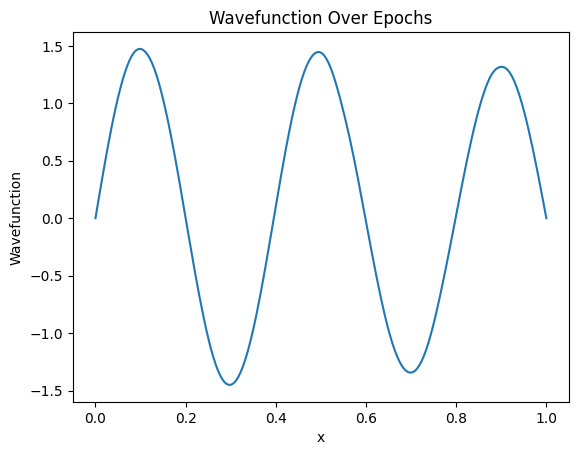

Epoch 365000, Total Loss: 232.04588317871094, Schrodinger Loss: 223.88108825683594, Norm Loss: 0.3284142017364502, Energy: tensor([140.9706], grad_fn=<SelectBackward0>), Henryjin Loss: 7.836379051208496


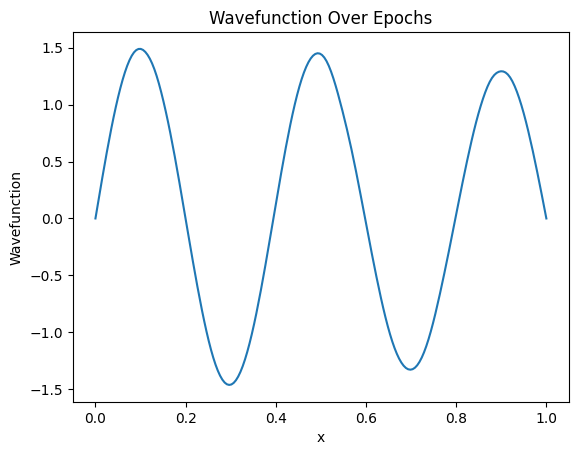

Epoch 370000, Total Loss: 284.5723876953125, Schrodinger Loss: 275.5936584472656, Norm Loss: 0.4474470019340515, Energy: tensor([142.9281], grad_fn=<SelectBackward0>), Henryjin Loss: 8.531266212463379


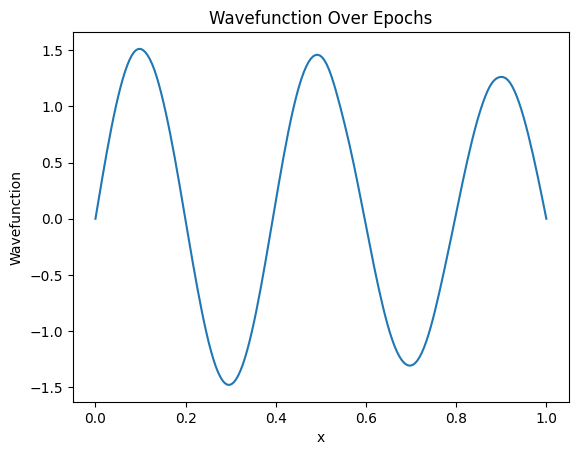

Epoch 375000, Total Loss: 342.03741455078125, Schrodinger Loss: 332.2220764160156, Norm Loss: 0.7077744603157043, Energy: tensor([144.8954], grad_fn=<SelectBackward0>), Henryjin Loss: 9.107575416564941


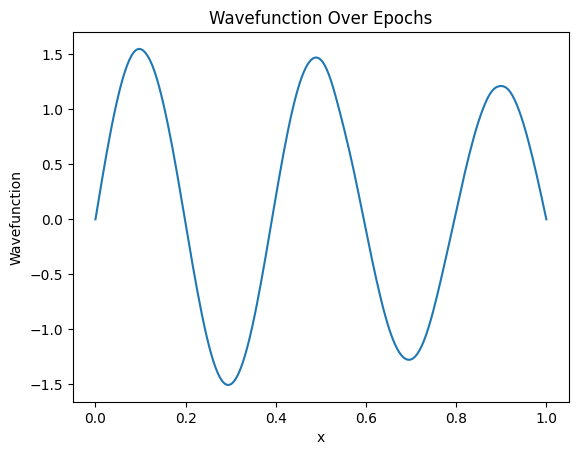

Epoch 380000, Total Loss: 403.32659912109375, Schrodinger Loss: 393.1000061035156, Norm Loss: 0.9891349077224731, Energy: tensor([146.8884], grad_fn=<SelectBackward0>), Henryjin Loss: 9.237457275390625


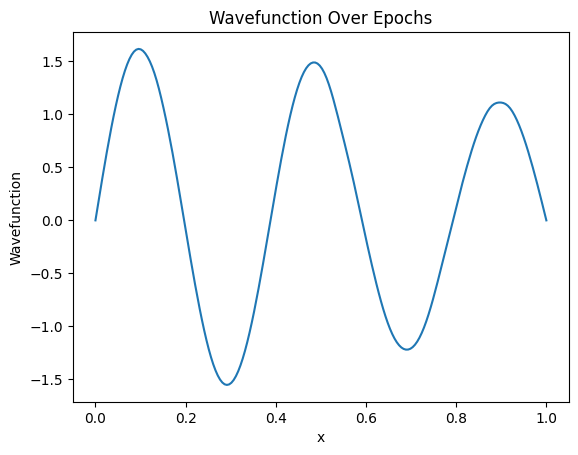

Epoch 385000, Total Loss: 400.98992919921875, Schrodinger Loss: 390.535400390625, Norm Loss: 1.004949927330017, Energy: tensor([148.8770], grad_fn=<SelectBackward0>), Henryjin Loss: 9.449592590332031


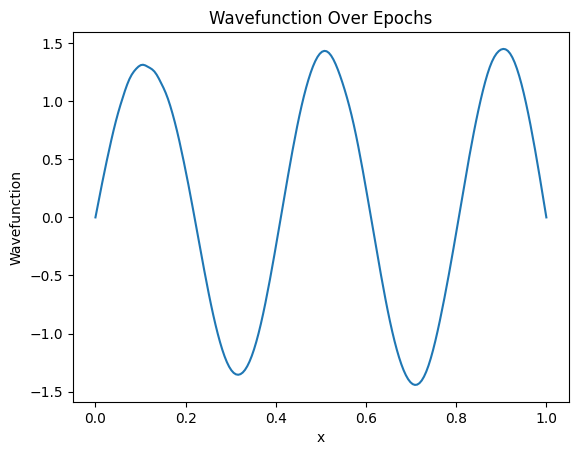

Epoch 390000, Total Loss: 230.26377868652344, Schrodinger Loss: 228.2609405517578, Norm Loss: 0.390777587890625, Energy: tensor([151.7612], grad_fn=<SelectBackward0>), Henryjin Loss: 1.6120531558990479


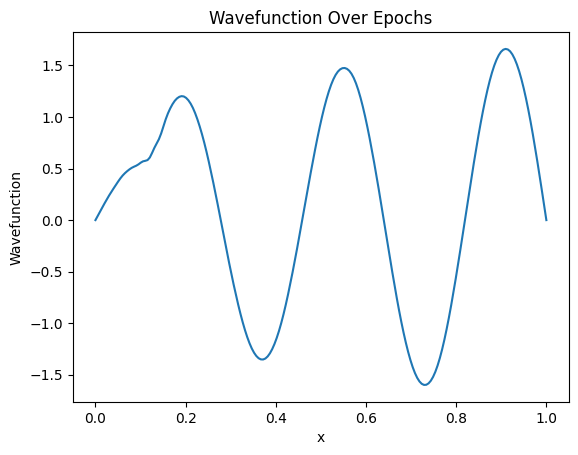

Epoch 395000, Total Loss: 205.486572265625, Schrodinger Loss: 204.72323608398438, Norm Loss: 0.22427022457122803, Energy: tensor([154.3090], grad_fn=<SelectBackward0>), Henryjin Loss: 0.5390645861625671


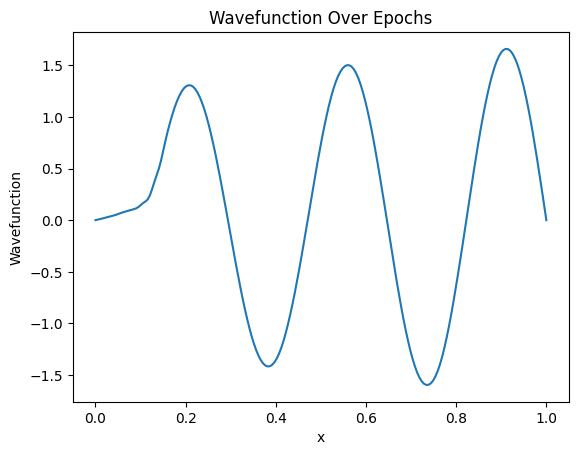

In [ ]:
# @title Varsayılan başlık metni
X = np.random.rand(200, 1)  # 200 rastgele nokta, 0 ile 1 arasında

pinns = PINNs(X)
pinns.train(epochs=400000)

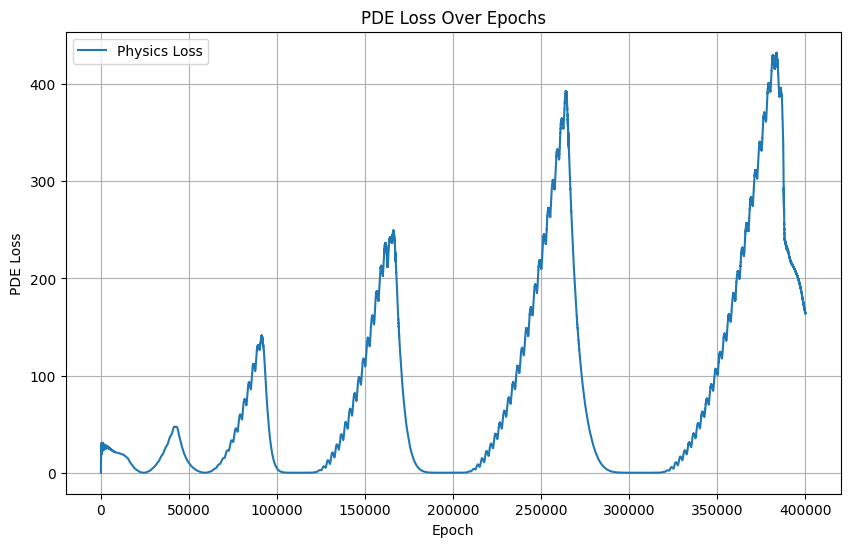

In [ ]:
pinns.plot_PDE_loss()

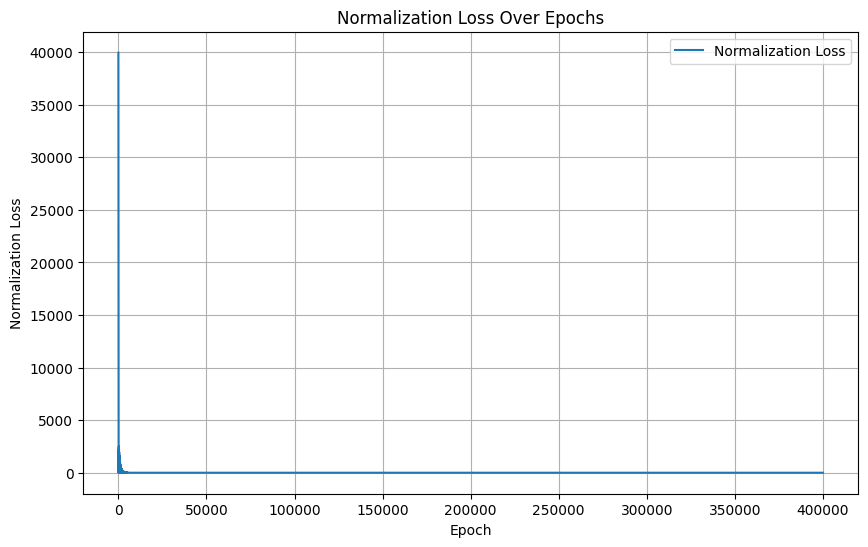

In [ ]:
pinns.plot_Norm_loss()

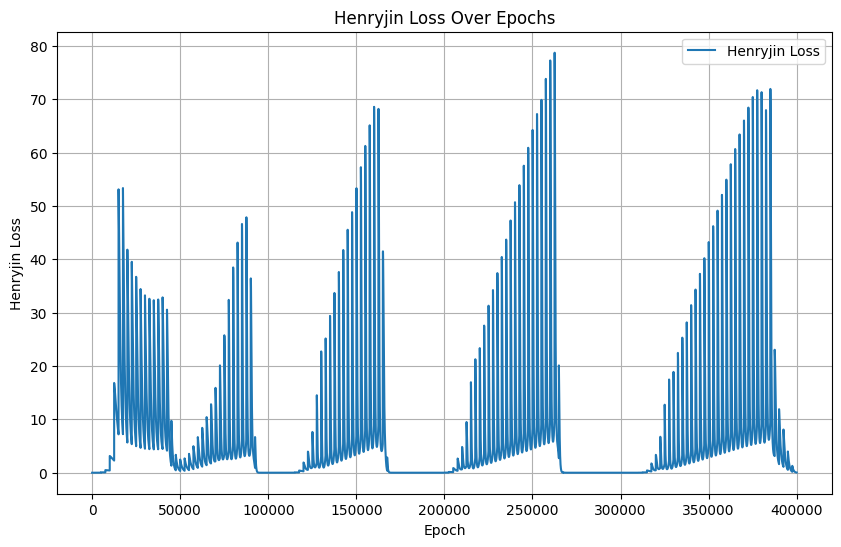

In [ ]:
pinns.plot_henryjin_loss()